In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import lightgbm as lgb
import datetime as dt
import catboost as ctb
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [3]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "Month", "TRF", "Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name"]
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [4]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [5]:
def preprocess(data, ada = True):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
  
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        imputer = SimpleImputer(strategy = "mean")
        cols = data.columns
        data = imputer.fit_transform(data)
        data = pd.DataFrame(data, columns = cols)       
        
    return (data)

In [6]:
df = preprocess(data, ada = True)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(df, df.Stage, test_size = 0.3, random_state = 0)

In [28]:
model = Sequential()
# model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

optimizer = keras.optimizers.Adam(lr = 0.015, beta_1 = 0.0, beta_2 = 0.0, epsilon = 0.000001, decay = 0.0, amsgrad = False)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit(x_train.drop(target, axis = 1).values, y_train.values, epochs = 250, validation_split = 0.25)

Train on 8863 samples, validate on 2955 samples
Epoch 1/250
8863/8863 [==============================] - 1s 109us/step - loss: 8.0627 - acc: 0.4975 - val_loss: 6.9849 - val_acc: 0.5645
Epoch 2/250
8863/8863 [==============================] - 1s 83us/step - loss: 7.2588 - acc: 0.5479 - val_loss: 6.9188 - val_acc: 0.5682
Epoch 3/250
8863/8863 [==============================] - 1s 88us/step - loss: 6.8700 - acc: 0.5710 - val_loss: 6.4937 - val_acc: 0.5878
Epoch 4/250
8863/8863 [==============================] - 1s 88us/step - loss: 6.8776 - acc: 0.5682 - val_loss: 6.7738 - val_acc: 0.5750
Epoch 5/250
8863/8863 [==============================] - 1s 88us/step - loss: 6.8896 - acc: 0.5678 - val_loss: 6.7663 - val_acc: 0.5753
Epoch 6/250
8863/8863 [==============================] - 1s 89us/step - loss: 6.8861 - acc: 0.5678 - val_loss: 6.7661 - val_acc: 0.5753
Epoch 7/250
8863/8863 [==============================] - 1s 88us/step - loss: 6.8858 - acc: 0.5680 - val_loss: 6.7686 - val_acc: 0.5753

8863/8863 [==============================] - 1s 82us/step - loss: 6.8847 - acc: 0.5680 - val_loss: 6.7791 - val_acc: 0.5746
Epoch 61/250
8863/8863 [==============================] - 1s 84us/step - loss: 6.8855 - acc: 0.5679 - val_loss: 6.7773 - val_acc: 0.5746
Epoch 62/250
8863/8863 [==============================] - 1s 81us/step - loss: 6.8846 - acc: 0.5681 - val_loss: 6.7798 - val_acc: 0.5746
Epoch 63/250
8863/8863 [==============================] - 1s 69us/step - loss: 6.8850 - acc: 0.5680 - val_loss: 6.7789 - val_acc: 0.5746
Epoch 64/250
8863/8863 [==============================] - 1s 72us/step - loss: 6.8839 - acc: 0.5681 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 65/250
8863/8863 [==============================] - 1s 69us/step - loss: 6.8858 - acc: 0.5680 - val_loss: 6.7783 - val_acc: 0.5746
Epoch 66/250
8863/8863 [==============================] - 1s 70us/step - loss: 6.8853 - acc: 0.5681 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 67/250
8863/8863 [==============================

8863/8863 [==============================] - 1s 72us/step - loss: 6.8857 - acc: 0.5681 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 120/250
8863/8863 [==============================] - 1s 68us/step - loss: 6.8855 - acc: 0.5681 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 121/250
8863/8863 [==============================] - 1s 75us/step - loss: 6.8833 - acc: 0.5682 - val_loss: 6.7746 - val_acc: 0.5750
Epoch 122/250
8863/8863 [==============================] - 1s 75us/step - loss: 6.8839 - acc: 0.5681 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 123/250
8863/8863 [==============================] - 1s 71us/step - loss: 6.8839 - acc: 0.5682 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 124/250
8863/8863 [==============================] - 1s 69us/step - loss: 6.8839 - acc: 0.5682 - val_loss: 6.7765 - val_acc: 0.5750
Epoch 125/250
8863/8863 [==============================] - 1s 72us/step - loss: 6.8840 - acc: 0.5681 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 126/250
8863/8863 [=======================

8863/8863 [==============================] - 1s 68us/step - loss: 6.8846 - acc: 0.5681 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 179/250
8863/8863 [==============================] - 1s 67us/step - loss: 6.8843 - acc: 0.5680 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 180/250
8863/8863 [==============================] - 1s 67us/step - loss: 6.8842 - acc: 0.5681 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 181/250
8863/8863 [==============================] - 1s 67us/step - loss: 6.8859 - acc: 0.5680 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 182/250
8863/8863 [==============================] - 1s 68us/step - loss: 6.8841 - acc: 0.5681 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 183/250
8863/8863 [==============================] - 1s 70us/step - loss: 6.8838 - acc: 0.5681 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 184/250
8863/8863 [==============================] - 1s 67us/step - loss: 6.8853 - acc: 0.5681 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 185/250
8863/8863 [=======================

8863/8863 [==============================] - 1s 87us/step - loss: 6.8827 - acc: 0.5682 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 238/250
8863/8863 [==============================] - 1s 95us/step - loss: 6.8822 - acc: 0.5682 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 239/250
8863/8863 [==============================] - 1s 82us/step - loss: 6.8813 - acc: 0.5683 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 240/250
8863/8863 [==============================] - 1s 87us/step - loss: 6.8813 - acc: 0.5683 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 241/250
8863/8863 [==============================] - 1s 96us/step - loss: 6.8813 - acc: 0.5682 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 242/250
8863/8863 [==============================] - 1s 90us/step - loss: 6.8815 - acc: 0.5682 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 243/250
8863/8863 [==============================] - 1s 89us/step - loss: 6.8803 - acc: 0.5684 - val_loss: 6.7764 - val_acc: 0.5750
Epoch 244/250
8863/8863 [=======================

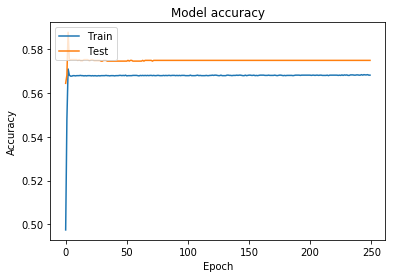

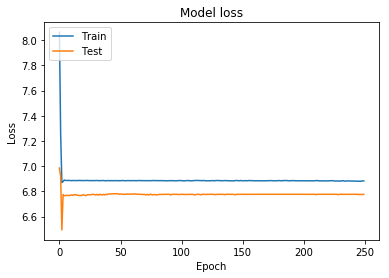

In [35]:
y_test_pred = model.predict_proba(x_test.drop(target, axis = 1).values)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [34]:
history.history['val_acc']

[0.5644670051568252,
 0.5681895093869437,
 0.587817258943761,
 0.5749576988962499,
 0.5752961083717153,
 0.5752961083717153,
 0.5752961083717153,
 0.5752961083717153,
 0.5752961083717153,
 0.5752961083717153,
 0.5749576988962499,
 0.5752961083717153,
 0.5749576988962499,
 0.5749576988962499,
 0.5749576988962499,
 0.5752961083717153,
 0.5752961083717153,
 0.5752961083717153,
 0.5752961083717153,
 0.5749576988962499,
 0.5749576988962499,
 0.5752961083717153,
 0.5752961083717153,
 0.5749576988962499,
 0.5749576988962499,
 0.5749576988962499,
 0.5749576988962499,
 0.5749576988962499,
 0.5749576988962499,
 0.5746192894207847,
 0.5746192894207847,
 0.5749576988962499,
 0.5749576988962499,
 0.5749576988962499,
 0.5746192894207847,
 0.5746192894207847,
 0.5746192894207847,
 0.5746192894207847,
 0.5746192894207847,
 0.5746192894207847,
 0.5746192894207847,
 0.5746192894207847,
 0.5746192894207847,
 0.5746192894207847,
 0.5746192894207847,
 0.5746192894207847,
 0.5746192894207847,
 0.57461928942